In [25]:
import cv2
import pytesseract 
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.animation
import numpy as np
import pandas as pd
import seaborn as sns
import math
from IPython.display import HTML
from scipy import stats
from scipy.signal import butter, lfilter

In [14]:
data = pd.read_excel('DigitalData.xlsx', sheet_name = 'CPET')
patient_info = pd.read_excel('DigitalData.xlsx', sheet_name = 'Patient')
patient_info['BMI']=patient_info['weight-kg']/(patient_info['height-cm']/100)**2
data_filt=data[['PatientId','Time','TestLevel','HR','VO2','VO2/kg','VCO2','VE','VEO2','VECO2','FE02','FECO2','RER','RR','METS','TMSPD','TMELV','Source','TypeUser']]

In [15]:
minutes = []
for i in data_filt.Time:
    minutes.append(i.second/60+i.minute)
data_filt['minutes']=np.array(minutes)

C:\Users\julio\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
patients_complete_only = data_filt.dropna().copy()
patients_complete_only['VO2/HR']=patients_complete_only.VO2/patients_complete_only.HR*1000
final_info = patients_complete_only.join(patient_info.set_index('patientid'), on="PatientId")
final_info['ID'] = final_info.index

# Calculating Pulmonary Limitation based on the Hardy Paper

In [17]:
final_info['VE/VCO2']=final_info['VE']/final_info['VCO2']
final_info['MVV_real'] = final_info.groupby(['PatientId'])['FE02'].transform(max)
for pid in final_info.PatientId.drop_duplicates().values:
    df_pid = final_info.loc[final_info.PatientId==pid]
    first_time = np.min(df_pid.minutes.values)
    base_value = df_pid.loc[(df_pid.minutes == first_time)].FE02.values*40
    final_info.loc[(final_info.PatientId == pid) ,'MVV_real']=base_value
    pass

In [18]:
final_info['PulmonaryLimitation']=final_info['VE']/final_info['MVV_real']
final_info['PulmonaryLimitationMax'] = final_info.groupby(['PatientId'])['PulmonaryLimitation'].transform(max)

# Getting the O2

In [19]:
final_info['O2']=final_info.VO2/final_info.HR*1000
final_info.head()

PatientId      Time TestLevel     HR   VO2  VO2/kg  VCO2     VE  VEO2  \
135          4  00:00:16    Warmup  108.0  0.48     4.5  0.41  14.90  31.0   
136          4  00:00:31    Warmup  109.0  0.49     5.5  0.52  18.94  32.0   
137          4  00:00:47    Warmup  105.0  0.63     5.9  0.56  20.47  32.0   
138          4  00:01:03    Warmup  108.0  0.44     4.1  0.43  16.71  38.0   
139          4  00:01:15    Warmup  111.0  0.48     4.5  0.50  19.80  41.0   

     VECO2  ...  year_of_test  Place  Place2  BMI   ID    VE/VCO2  MVV_real  \
135   36.0  ...           NaN    NaN     NaN  NaN  135  36.341463     688.8   
136   37.0  ...           NaN    NaN     NaN  NaN  136  36.423077     688.8   
137   36.0  ...           NaN    NaN     NaN  NaN  137  36.553571     688.8   
138   39.0  ...           NaN    NaN     NaN  NaN  138  38.860465     688.8   
139   39.0  ...           NaN    NaN     NaN  NaN  139  39.600000     688.8   

    PulmonaryLimitation PulmonaryLimitationMax        O2  
135            0.021632               0.163429  4.444444  
136            0.027497               0.163429  4.495413  
137            0.029718               0.163429  6.000000  
138            0.024260               0.163429  4.074074  
139            0.028746               0.163429  4.324324  

[5 rows x 38 columns]

# Getting the Cardiac Limitation

In [20]:
final_info['CardiacDef'] = -1
for pid in final_info.PatientId.drop_duplicates().values:
    df_pid = final_info.loc[final_info.PatientId==pid]
    if df_pid.O2.values[0] == np.inf:
        continue
    min_mid = range(int(np.round(df_pid.shape[0]/4)),int(np.round(df_pid.shape[0]/2)))
    max_mid = range(int(np.round(df_pid.shape[0]/2)),int(np.round(3*df_pid.shape[0]/4)))
    df_min = df_pid.iloc[min_mid,:]
    df_max = df_pid.iloc[max_mid,:]
    x_df_min = df_min.minutes.values
    y_df_min = df_min.O2.values
    x_df_max = df_max.minutes.values
    y_df_max = df_max.O2.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_min, y_df_min)
    atan_inf = np.arctan(slope)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_max, y_df_max)
    atan_sup = np.arctan(slope)
    final_info.loc[(final_info.PatientId == pid),'CardiacDef']=np.abs(atan_inf-atan_sup)/(np.pi/2)
    pass

# Getting the Skeletal deficienciy

In [21]:
plot_it = False
for pid in final_info.PatientId.drop_duplicates().values:
    df_pid = final_info.loc[(final_info.PatientId==pid) #& (final_info.TestLevel == 'Exercise')  
                            & (final_info.minutes > 0)]
    df_pid_slope = df_pid.copy()
    slope_index = range(int(np.round(df_pid.shape[0]/3.25)),int(np.round(df_pid.shape[0]/2)))
    df_pid_slope = df_pid_slope.iloc[slope_index,:]
    x_df = df_pid.minutes.values
    y_df = df_pid.VCO2.values
    x_df_slope = df_pid_slope.minutes.values
    y_df_slope = df_pid_slope.VCO2.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_df_slope, y_df_slope)
    times = df_pid.minutes
    y_est = times * slope + intercept
    y_error = df_pid.VCO2.values - y_est
    indexes = np.where(y_error>0.5)
    at_time = x_df[-1]
    if(indexes[0].size >0):
        at_time = x_df[indexes[0][0]]
        pass
    final_info.loc[(final_info.PatientId == pid),'SkeletalLimit']=np.abs(x_df[-1]-at_time)/x_df[-1]
    if plot_it is True:
        print(indexes[0])
        print(x_df[indexes[0]])
        print(at_time)
        print(x_df[-1])
        print(np.abs(x_df[-1]-at_time)/x_df[-1])
        #print(y_est[indexes])
        #print(x_df[indexes])
        faux_y = slope * df_pid.minutes.values + intercept
        #plt.annotate('Turning Point', xy=(y_error[]))
        plt.title("Plotting for {}: {}".format(pid, df_pid.TypeUser.values[0]))
        plt.plot(df_pid.minutes.values, df_pid.VCO2.values)
        plt.plot(df_pid.minutes.values, faux_y)
        plt.xlabel('time(min)')  
        plt.ylabel('VO2') 
        plt.show()
    pass

In [22]:
type_patient_dict = {"Unknown": None, "YoungAthlete": "young athlete", "HealthyNonAthlete": "Healthy non athlete"}
def radar_plot_limitations(patient_id, pulmonary, cardiac, skeletal, patient_type="Unknown"):
    categories = ['Pulmonary limitation', 'Cardiac limitation', 'Skeletal limitation']
    patient_type_value = type_patient_dict[patient_type]
    N = len(categories)
    values = [pulmonary,cardiac,skeletal]
    values += values[:1]
    angles = [n/ float(N)*2*np.pi for n in range(N)]
    angles += angles[:1]
    #plt.title("Radar plot limitation for patient {}".format(patient_id))
    #plt.title("REEE")
    if patient_type_value is not None:
        print('Patient {} is a {}'.format(i,patient_type_value))
    plt.polar(angles, values)
    plt.xticks(angles[:-1], categories)
    plt.ylim(0,1)
    plt.show()

In [23]:
df_patient_resume = final_info[['PatientId','SkeletalLimit','CardiacDef','PulmonaryLimitationMax','TypeUser']].drop_duplicates()
df_patient_resume = df_patient_resume.loc[df_patient_resume.CardiacDef >= 0]
df_patient_resume

PatientId  SkeletalLimit  CardiacDef  PulmonaryLimitationMax  \
135           4       0.976744    0.079635                0.163429   
181           5       0.000000    0.057481                0.086511   
232           6       0.000000    0.360773                0.154335   
288           7       0.253968    0.013319                0.059895   
351           8       0.124088    0.226342                0.082082   
406           9       0.247986    0.011202                0.140867   
481          10       0.235242    0.203113                0.224371   
556          11       0.415347    0.089151                0.158245   
611          12       0.350450    0.071401                0.227396   
685          13       0.238498    0.072878                0.116760   
756          14       0.000000    0.175078                0.112454   
837          15       0.000000    0.024154                0.041170   
951          17       0.250892    0.221251                0.327619   
1007         18       0.301887    0.180676                0.272386   
1060         19       0.000000    0.327443                0.164589   
1139         20       0.979038    0.673881                0.105865   
1193         21       0.276693    0.409457                0.077425   

               TypeUser  
135             Unknown  
181             Unknown  
232             Unknown  
288             Unknown  
351             Unknown  
406        YoungAthlete  
481        YoungAthlete  
556        YoungAthlete  
611        YoungAthlete  
685             Unknown  
756             Unknown  
837             Unknown  
951        YoungAthlete  
1007       YoungAthlete  
1060  HealthyNonAthlete  
1139  HealthyNonAthlete  
1193  HealthyNonAthlete

Radar plot for patient 4


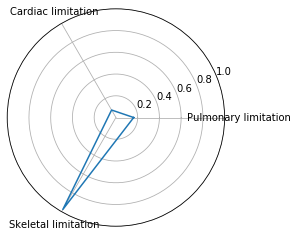

Radar plot for patient 5


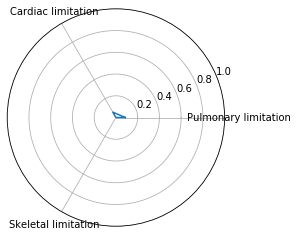

Radar plot for patient 6


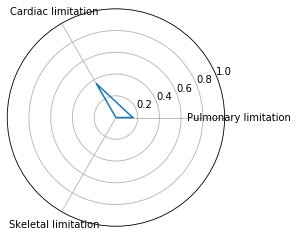

Radar plot for patient 7


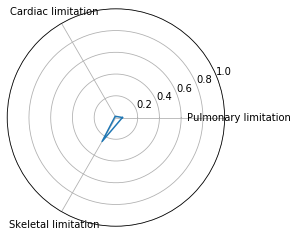

Radar plot for patient 8


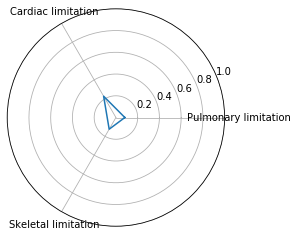

Radar plot for patient 9
Patient 9 is a young athlete


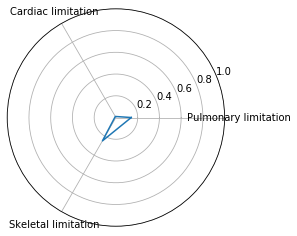

Radar plot for patient 10
Patient 10 is a young athlete


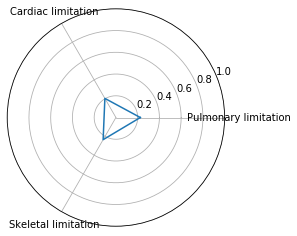

Radar plot for patient 11
Patient 11 is a young athlete


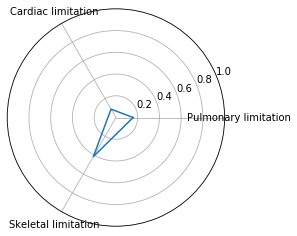

Radar plot for patient 12
Patient 12 is a young athlete


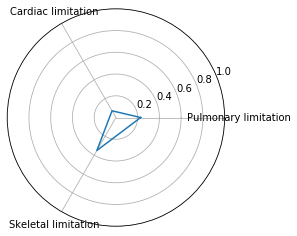

Radar plot for patient 13


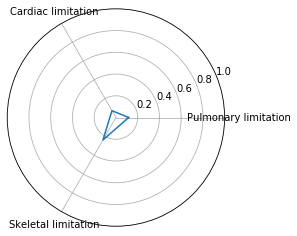

Radar plot for patient 14


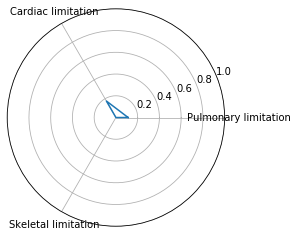

Radar plot for patient 15


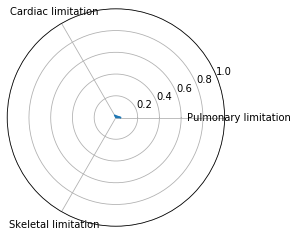

Radar plot for patient 17
Patient 17 is a young athlete


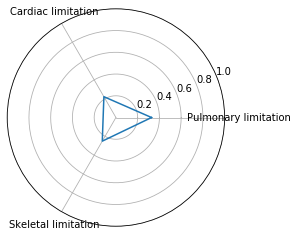

Radar plot for patient 18
Patient 18 is a young athlete


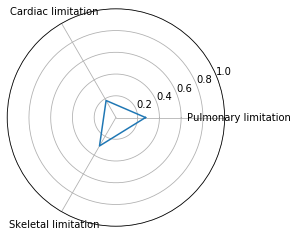

Radar plot for patient 19
Patient 19 is a Healthy non athlete


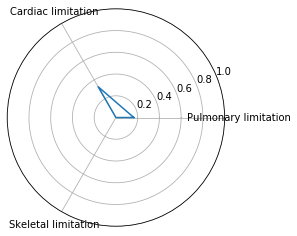

Radar plot for patient 20
Patient 20 is a Healthy non athlete


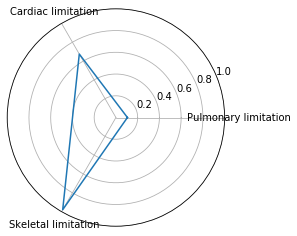

Radar plot for patient 21
Patient 21 is a Healthy non athlete


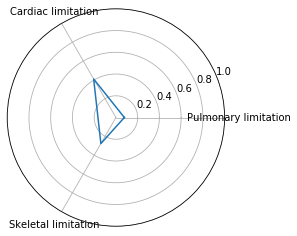

In [24]:
for i in df_patient_resume.PatientId.values:
    resume = df_patient_resume.loc[df_patient_resume.PatientId==i]
    print('Radar plot for patient {}'.format(i))
    radar_plot_limitations(resume.PatientId.values[0], resume.PulmonaryLimitationMax.values[0],
                           resume.CardiacDef.values[0], resume.SkeletalLimit.values[0],resume.TypeUser.values[0])
    pass